## Source

- The source code comes from [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention).

- More detailed explanation can be read from [here](https://machinelearningmastery.com/the-luong-attention-mechanism/).

## Data

The code snippet is responsible for generating synthetic data to train a neural network model. The `batch_size` variable defines how many examples will be processed at once during training, which is set to 32. The `max_sequence_length` is a hyperparameter that specifies the length of the input sequences, and it's set to 10; this value can be adjusted based on the specific requirements of the dataset or the model architecture. `num_samples` is the total number of training examples to be generated, here equal to 1000. Using NumPy's `random.randint` function, two datasets `fake_query_data` and `fake_value_data` are created, each consisting of 1000 samples where each sample is a sequence of 10 integers (representing tokens), and each integer can range from 0 to 999. Similarly, `fake_labels` is created as a binary target variable for each sample, suitable for a binary classification task.


In [ ]:
from tqdm import tqdm

In [ ]:
# Generate fake data
batch_size = 32
max_sequence_length = 64  # You can set the sequence length to what makes sense for your problem
num_samples = 1000  # Number of samples in fake data

# Create fake data with the correct dimensions
fake_query_data = np.random.randint(1000, size=(num_samples, max_sequence_length))
fake_value_data = np.random.randint(1000, size=(num_samples, max_sequence_length))
# fake_labels = np.random.randint(2, size=(num_samples, 1))
module_1 = (fake_query_data[:, 0] + fake_query_data[:, 1]) % 2
module_2 = (fake_query_data[:, 2] + fake_query_data[:, 3]) % 2

fake_labels = []
for i in tqdm(range(num_samples)):
    if np.random.randint(0, 2):
        fake_labels.append(module_1[i])
    else:
        fake_labels.append(module_2[i])

100%|██████████| 1000/1000 [00:00<00:00, 158875.15it/s]


In [ ]:
fake_labels = np.array(fake_labels)
fake_labels[:20]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0])

In [ ]:
print(fake_query_data.shape)
print(fake_value_data.shape)
print(fake_labels.shape)

(1000, 64)
(1000, 64)
(1000,)


## Model Architecture Explanation

The given code defines a neural network model using TensorFlow, particularly with its high-level API, Keras. The model is designed to process sequences of integers, which could represent words or tokens in a natural language processing context.

First, the code imports the required TensorFlow and NumPy libraries. It then defines two input layers: `query_input` and `value_input`. Both are expected to receive sequences of integers of variable length, as denoted by `shape=(None,)`, and the data type specified is `int32`.

An embedding layer, `token_embedding`, is then declared, which is capable of mapping each integer in the sequences to a 64-dimensional vector space. The input dimension is set to 1000, meaning the layer can handle 1000 unique tokens. The `query_embeddings` and `value_embeddings` are generated by passing `query_input` and `value_input` through this embedding layer, effectively converting the token sequences into dense vectors that capture semantic information.

Following the embeddings, a 1D convolutional neural network (CNN) layer is applied to both sets of embeddings. This `cnn_layer` uses 100 filters and a kernel size of 4, with 'same' padding to ensure the output length is equal to the input length. The result of this operation is two sets of encoded sequences, `query_seq_encoding` and `value_seq_encoding`.

The code then employs an attention mechanism, specifically using the `Attention` layer, to compare the query and value encodings and generate a sequence that represents the weighted importance of the values with respect to the query.

Global average pooling is applied to both the query encoding and the combined query-value attention sequence. This operation reduces the sequence dimension, averaging out the features across the time steps, resulting in two fixed-size vectors.

These vectors are then concatenated to form a single input layer, `input_layer`, which serves as the combined representation of both the query and value information.

Next, the code defines a dense neural network layer with 64 units and a ReLU activation function to introduce non-linearity into the model. This is followed by the output layer, which is a single neuron with a sigmoid activation function, indicating the model is designed for binary classification.

Finally, the `model` is constructed by specifying the inputs and output layer. This model can now be compiled and trained on suitable data for tasks such as document retrieval, question answering, or any other scenario where the relationship between two sequences needs to be modeled.


In [ ]:
import tensorflow as tf
import numpy as np

# Define the inputs
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup
token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=64)
# Query and value embeddings
query_embeddings = token_embedding(query_input)
value_embeddings = token_embedding(value_input)

# CNN layer
cnn_layer = tf.keras.layers.Conv1D(filters=100, kernel_size=4, padding='same')
# Encoded sequences
query_seq_encoding = cnn_layer(query_embeddings)
value_seq_encoding = cnn_layer(value_embeddings)

# Attention layer
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

# Global Average Pooling
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(query_seq_encoding)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(query_value_attention_seq)

# Concatenate layer
input_layer = tf.keras.layers.Concatenate()([query_encoding, query_value_attention])

# Add DNN layers
dense_layer = tf.keras.layers.Dense(64, activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model = tf.keras.Model(inputs=[query_input, value_input], outputs=output_layer)

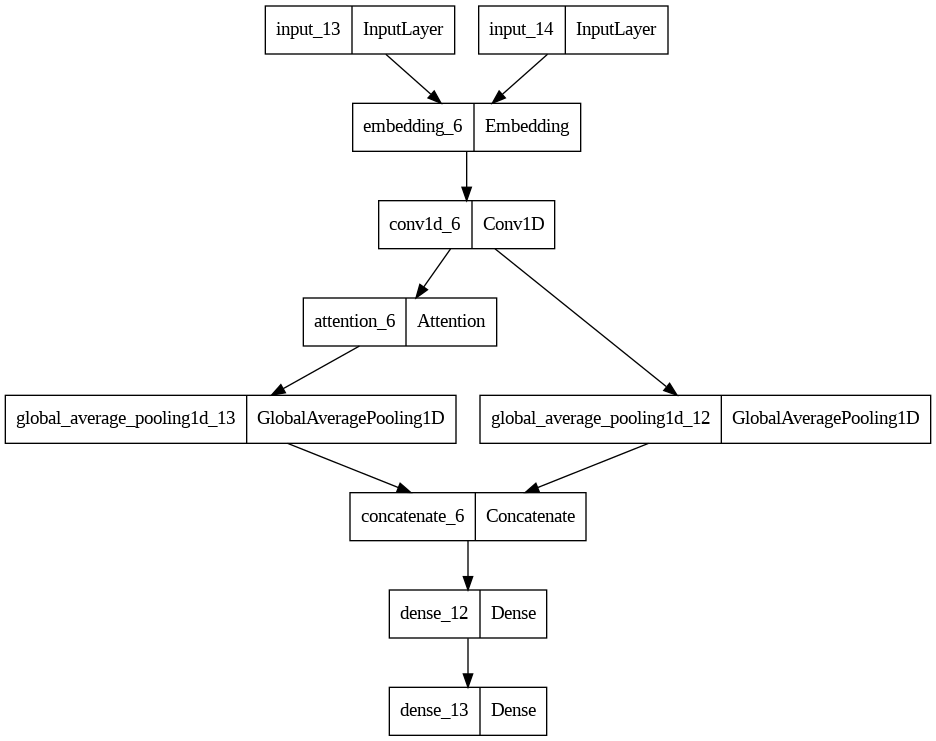

In [ ]:
tf.keras.utils.plot_model(model)

### Model Compilation Explanation

The code snippet is a crucial step in preparing the neural network model for training. The `compile` method is used to configure the model with the necessary settings for the training process.

The `optimizer` parameter is set to 'adam', which refers to the Adam optimization algorithm. Adam is an adaptive learning rate optimization algorithm designed to handle sparse gradients on noisy problems. It's a popular choice due to its efficiency and minimal memory requirement.

The `loss` parameter is set to 'binary_crossentropy', which is the loss function used for binary classification problems. Crossentropy loss measures the performance of a classification model whose output is a probability value between 0 and 1. Binary crossentropy loss is used when there are only two label classes (labels are supposed to be 0 and 1).

Lastly, the `metrics` parameter includes 'accuracy' as a metric to be evaluated by the model during training and testing. Accuracy calculates how often predictions equal labels, providing a measure of how many instances were correctly classified.

By compiling the model with these parameters, we are essentially setting up the model for the backpropagation process: the optimizer will minimize the loss function, improving the model's accuracy over iterations of training.

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model Training Explanation

The code snippet provided is used to train the neural network model with synthetic data. The `fit` method of the `model` object is used to feed the data into the model and to perform the training process.

- The first argument to `model.fit` is a list containing `fake_query_data` and `fake_value_data`, which are the input features for the model. These should be numpy arrays or tensors containing the input data. In this context, it appears that these arrays represent encoded sequences of data that the model will learn from.

- The second argument, `fake_labels`, represents the target outputs that the model should learn to predict. These labels are associated with the input data and in binary classification tasks, such as the one implied by the preceding code, they would typically consist of 0s and 1s indicating the class of each sample.

- `batch_size=batch_size` tells the `fit` method how many samples to process before updating the model's weights. `batch_size` is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. Here, it is set to the variable `batch_size` which was defined earlier in the code (not shown in this snippet but typically would be an integer value).

- `epochs=10` specifies the number of epochs to run the training for, which is the number of complete passes through the entire training dataset. An epoch is one complete presentation of the data set to be learned to a learning machine. Running for 10 epochs means that the entire dataset will be passed through the neural network a total of 10 times.

By executing this `fit` method, the model will start the training process, adjusting its weights on the synthetic data for 10 iterations over the dataset, optimizing the loss function specified during the compilation step, and trying to improve the accuracy metric that was also set previously.

In [ ]:
# Fit the model with fake data
model.fit(
    [fake_query_data, fake_value_data],
    fake_labels,
    batch_size=batch_size,
    epochs=10)

Epoch 1/10
32/32 [==============================] - 1s 17ms/step - loss: 0.6938 - accuracy: 0.4830
Epoch 2/10
32/32 [==============================] - 1s 17ms/step - loss: 0.6853 - accuracy: 0.6190
Epoch 3/10
32/32 [==============================] - 1s 28ms/step - loss: 0.5792 - accuracy: 0.7670
Epoch 4/10
32/32 [==============================] - 1s 24ms/step - loss: 0.3071 - accuracy: 0.9020
Epoch 5/10
32/32 [==============================] - 1s 21ms/step - loss: 0.1207 - accuracy: 0.9710
Epoch 6/10
32/32 [==============================] - 1s 32ms/step - loss: 0.0593 - accuracy: 0.9900
Epoch 7/10
32/32 [==============================] - 1s 24ms/step - loss: 0.0207 - accuracy: 0.9980
Epoch 8/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 9/10
32/32 [==============================] - 1s 31ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 10/10
32/32 [==============================] - 1s 17ms/step - loss: 0.0021 - accuracy: 1.0000
